In [19]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [20]:
import helpers as hp

In [11]:
root_dir = "data/training/"
image_dir = root_dir + "images/"
gt_dir = root_dir + "groundtruth/"

files = os.listdir(image_dir)

#generate more training data by rotaing the images 90, 180 and 270 degrees --> genrates 400 images

for i in range(len(files)):
    hp.rotate_img(image_dir+files[i], 90)
    hp.rotate_img(gt_dir+files[i], 90)
    hp.rotate_img(image_dir+files[i], 180)
    hp.rotate_img(gt_dir+files[i], 180)
    hp.rotate_img(image_dir+files[i], 270)
    hp.rotate_img(gt_dir+files[i], 270)
    

In [12]:
files=os.listdir(image_dir)
print(len(files))

#Rotate all the images again by 45 degrees --> generates 800 images
for i in range(len(files)):
  hp.rotate_crop_img(image_dir+files[i],45)
  hp.rotate_crop_img(gt_dir+files[i],45)

400


In [21]:
root_dir = "data/training/"
gt_dir = root_dir + "groundtruth/"
image_dir = root_dir + "images/"

files= os.listdir(image_dir)
n = len(files) 


print("Loading " + str(n) + " images")
imgs = [hp.load_image(image_dir + files[i]) for i in range(n)]


gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [hp.load_image(gt_dir + files[i]) for i in range(n)]


Loading 100 images
Loading 100 images


Image size = 400,400


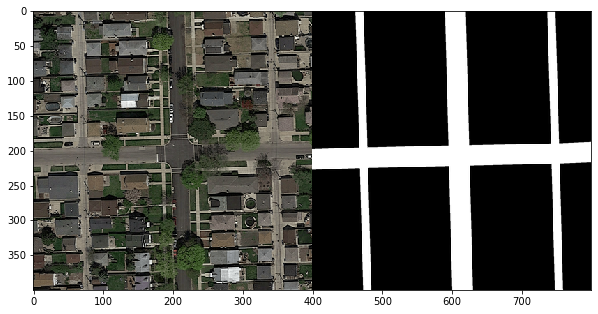

In [22]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = hp.concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

Image size = 400,400


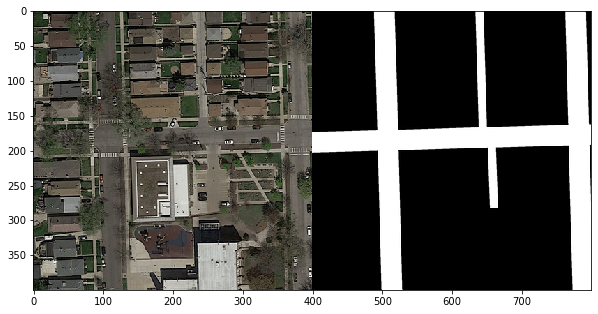

In [23]:
print('Image size = ' + str(imgs[1].shape[0]) + ',' + str(imgs[1].shape[1]))

# Show first image and its groundtruth image
cimg = hp.concatenate_images(imgs[1], gt_imgs[1])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [24]:
#Train the model on the first 700 images and run validation on last 100 images
N_train=80
N_val=20

In [25]:

patch_size = 16

#Crop the images to patches of size 16*16 pixels
img_patches = [hp.img_crop(imgs[i], patch_size, patch_size) for i in range(N_train)]
gt_patches = [hp.img_crop(gt_imgs[i], patch_size, patch_size) for i in range(N_train)]

print(np.shape(img_patches))
print(np.shape(gt_patches))


#Combine all the patches in one list
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))]) #combine the patches of each image
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

print(np.shape(img_patches))
print(np.shape(gt_patches))

(80, 625, 16, 16, 3)
(80, 625, 16, 16)
(50000, 16, 16, 3)
(50000, 16, 16)


In [26]:
#Extracting 124 features from the RGB colors of each patch
X_aug= np.asarray([hp.extract_features_124(img_patches[i]) for i in range(len(img_patches))])

#Converting the groundtruth patches to values of 0 or 1, the threshold is 0.33
Y = np.asarray([hp.value_to_class(np.mean(gt_patches[i]), 0.33) for i in range(len(gt_patches))])

In [27]:
# Print feature statistics

print('Computed ' + str(X_aug.shape[0]) + ' features')
print('Feature dimension = ' + str(X_aug.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) #either 1 or 0

Y0 = [i for i, j in enumerate(Y) if j == 0] #collect the patches that are 0
Y1 = [i for i, j in enumerate(Y) if j == 1] #colect the patches that are 1
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 50000 features
Feature dimension = 124
Number of classes = 1
Class 0: 38184 samples
Class 1: 11816 samples


In [28]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced",max_iter=1000)

logreg.fit(X_aug, Y)

C:\Users\levit\Anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
#Running Predictions on the Validation Set

patch_size = 16

#Crop the images to patches of size 16*16 pixels
img_patches_val = [hp.img_crop(imgs[i], patch_size, patch_size) for i in range(N_train,N_train+N_val)]
gt_patches_val = [hp.img_crop(gt_imgs[i], patch_size, patch_size) for i in range(N_train,N_train+N_val)]

print("Shape of the validation image patches: "+str(np.shape(gt_patches_val)))
print("Shape of the validation ground truth patches: "+str(np.shape(gt_patches_val)))


#Combine all the patches in one list
img_patches_val = np.asarray([img_patches_val[i][j] for i in range(len(img_patches_val)) for j in range(len(img_patches_val[i]))]) #combine the patches of each image
gt_patches_val =  np.asarray([gt_patches_val[i][j] for i in range(len(gt_patches_val)) for j in range(len(gt_patches_val[i]))])

X_aug= np.asarray([hp.extract_features_124(img_patches_val[i]) for i in range(len(img_patches_val))])

Y_val = np.asarray([hp.value_to_class(np.mean(gt_patches_val[i]), 0.33) for i in range(len(gt_patches_val))])

Y_val_pred=logreg.predict(X_aug)




Shape of the validation image patches: (20, 625, 16, 16)
Shape of the validation ground truth patches: (20, 625, 16, 16)


In [30]:
from sklearn.metrics import f1_score

def compute_f1_score(y_pred, y):
        score = f1_score(y_pred, y, average="binary")
        return score

f1=compute_f1_score(Y_val_pred, Y_val)
    
print("F1 score of the validation set is: "+str(f1))

F1 score of the validation set is: 0.4958424507658643


In [31]:
img_idx=0
root_dir_test = "data/"
image_dir_test = root_dir_test + "test_set_images/"


patch_size=16
degree=5

files_test= os.listdir(image_dir_test)
file=os.listdir(image_dir_test + files_test[img_idx])


img=hp.load_image(image_dir_test + files_test[img_idx]+"/"+file[0])
print("Running prediction on: "+image_dir_test + files_test[img_idx]+"/"+file[0])

print(img.shape)
img_patch=hp.img_crop(img, patch_size, patch_size)

Xi=np.asarray([hp.extract_features_124(img_patch[i]) for i in range(len(img_patch))])

Zi=logreg.predict(Xi)




Running prediction on: data/test_set_images/test_1/test_1.png
(608, 608, 3)


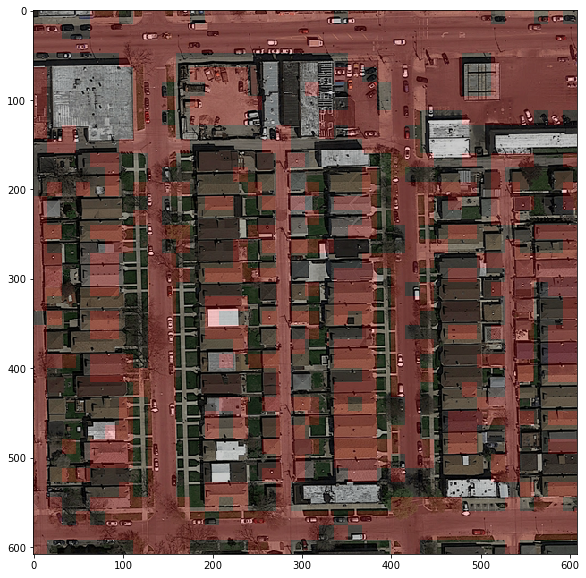

In [32]:
#Creating an overlay from the prediction
w = img.shape[0]
h = img.shape[1]
predicted_im = hp.label_to_img(w, h, patch_size, patch_size, Zi)



cimg = hp.concatenate_images(img, predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = hp.make_img_overlay(img, predicted_im)

plt.imshow(new_img)

In [33]:
import mask_to_submission as ms

In [34]:
index=0
test_dir = "Datasets/test_set_images/test_"
s=[]
for i in range(1,51):
    s.append(test_dir + np.str(i) + "/" + "test_" + np.str(i) + ".png")
imgs_test = [hp.load_image(s[i]) for i in range(50)]



In [38]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


patch_size=16

prediction_files=[] 

#Save the predictions to a file
for i in range(len(s)):
  img=hp.load_image(s[i])

  img_patch=hp.img_crop(img, patch_size, patch_size)
    
  Xi=np.asarray([hp.extract_features_124(img_patch[i]) for i in range(len(img_patch))])

  Zi=logreg.predict(Xi)
    
  w = img.shape[0]
  h = img.shape[1]
    
  predicted_im = hp.label_to_img(w, h, patch_size, patch_size, Zi)
  plt.imsave('data/test_set_pred/test_'+str(i+1)+'test_'+str(i+1)'.png', predicted_im, cmap=cm.gray)

  prediction_files.append('data/test_set_pred/test_'+str(i+1)+'test_'+str(i+1)'.png') #Saves the name of the pediction file


print("Saving prediction for " +str(i+1)+" test set images "+"in " +"data/test_set_pred/ " +"directory.")
  

SyntaxError: invalid syntax (<ipython-input-38-52e30c49a46f>, line 24)

In [ ]:
#Creating a submission file
submission_filename = "Submission_22.csv"
image_filenames = submission_files_name
ms.masks_to_submission(submission_filename, *image_filenames)

### Tensorflow Areal Images

##### Training the Neural Net

In [ ]:
import basic_convolutional_model as conv_model

In [ ]:
conv_model.main()

In [ ]:
import helpers as hp
import matplotlib.pyplot as plt

img=hp.load_image("predictions_training/overlay_10.png")
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(img)

In [ ]:
s_new=[]
for i in range(1,51):
    s_new.append('predictions_training/'+'prediction_'+str(i)+'.png')

In [ ]:
import mask_to_submission as ms

submission_filename = "Submission.csv"
image_filenames = s_new
ms.masks_to_submission(submission_filename, *image_filenames)

In [ ]:
#TF, 300 images score: F1:0.649 Secondary:0.757

##### Combining the predictions of logistic regression and TF Areal Images

In [ ]:


f1 = open("S10ubmission.csv")
f2 = open("S2ubmission.csv")
f3 = open('new_submission.csv', 'w') 

lines1 = f1.readlines()
lines2 = f2.readlines()

f3.write('id,prediction\n')

for i in range(1,72201):
    line_s1=lines1[i].split(",")
    line_s2=lines2[i].split(",")
    
    n=int(line_s1[1])*int(line_s2[1]) #outputs one if both predictions are 1, otherwise 0
   
    f3.write(line_s1[0]+','+str(n)+'\n')
